In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
from pytorch_eo.datasets import SEN12Floods
from pytorch_eo.datasets.sensors import Sensors, S1, S2
import timm 
import lightning as L
from pytorch_eo.tasks.classification import ImageClassification
import torch

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


# SEN12-FLOODS

In this example we are going to train 2 image classifiers using the [SEN12-FLOODS](https://mlhub.earth/data/sen12floods) dataset. `SEN12-FLOOD` is a set of multimodal (SAR + multispectral) satellite image time-series for flood classification. The observed areas correspond to 337 locations (cities and their surroundings ) in West and SouthEast Africa, Middle-East, and Australia where a flood event occurred during the considered period. The period of acquisition goes from December 2018 to May 2019.

For each location, the following data are provided:
- Time series of Sentinel-2 multispectral images. These images are composed of 12 bands,
at 10m ground-sampling distance and are provided with Level 2A atmospheric correction.
- Time series of Sentinel-1 Synthetic Aperture Radar (SAR) images. The images are provided
with radiometric calibration and range doppler terrain correction based on the SRTM digital
elevation model. For one acquisition, two raster images are available corresponding to the
polarimetry channels VV and VH.
- Time series of binary labels for each image / date: flood or no flood.
The original dataset was split into 262 sequences for the train and 68 sequences for the test.

As said, we are going to traing 2 image classifiers using different sensors:

1. Using S1 images.
2. Using S2 images.

Before doing anything, we need to download the dataset.

# Download the dataset

It can be done in different ways, but the easiest one is downloading it from the [EOTDL](https://www.eotdl.com/datasets). We can download it manually or using the `eotdl CLI`, which needs to be installed using `pip` as it based on the [eotdl Python library](https://github.com/earthpulse/eotdl). Let's do it, tt is as easy as follows.

```bash
# install the library
pip3 install eotdl   

# download the dataset
eotdl datasets get SEN12-FLOOD 

# extract it to your preferred folder
unzip ~/.eotdl/datasets/SEN12-FLOOD/SEN12-FLOOD.zip -d data/sen12floods
```

Once downloaded and extracted, you will have a folder with the following structure:

- sen12floods_s1_labels
- sen12floods_s1_source
- sen12floods_s2_labels
- sen12floods_s2_source

Then you can instantiate the Dataset as follows, selecting the sensors and bands that you want to work with.

## Sentinel-1

First of all, let's train a image classifier using images from Sentinel-1.

In [3]:
ds = SEN12Floods(
    sensor=Sensors.S1,
    bands=[S1.VH, S1.VV], 
) 

ds.setup()

Training samples 1999
Validation samples 666
Test samples 666


All out datasets have a `DataFrame` containing the required data to train the model. In this case, the list of images and labels. Use this object to explore the dataset.

In [4]:
ds.df

,image,label
0,data/sen12floods/sen12floods_s1_source/sen12fl...,0
1,data/sen12floods/sen12floods_s1_source/sen12fl...,0
2,data/sen12floods/sen12floods_s1_source/sen12fl...,0
3,data/sen12floods/sen12floods_s1_source/sen12fl...,0
4,data/sen12floods/sen12floods_s1_source/sen12fl...,1
...,...,...
3326,data/sen12floods/sen12floods_s1_source/sen12fl...,0
3327,data/sen12floods/sen12floods_s1_source/sen12fl...,1
3328,data/sen12floods/sen12floods_s1_source/sen12fl...,0
3329,data/sen12floods/sen12floods_s1_source/sen12fl...,0


In [5]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. You can extract data from the `Dataset`s objects or the `DataLoaders`. `PytorchEO` is designed to work with arbitrary number of inputs and outputs, so we use a `dict` to name the different tensors.

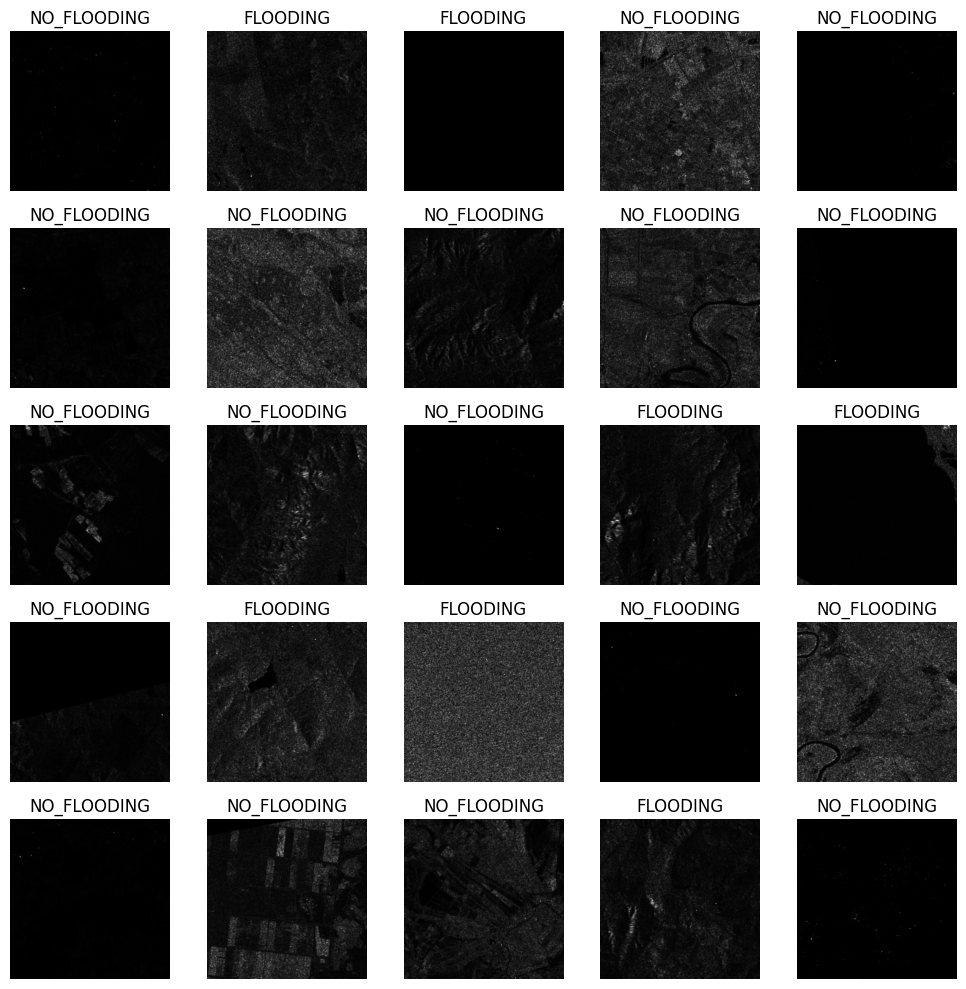

In [6]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    if img.ndim == 2:
        ax.imshow(img, cmap="gray") # one band 
    else:
        ax.imshow(img[0], cmap="gray") # first band
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Let's train our model! 

In [7]:
ds = SEN12Floods(
    batch_size=64,
    sensor=Sensors.S1,
    bands=[S1.VH, S1.VV],
    num_workers=4,
    pin_memory=True,
) 

model = timm.create_model(
    'resnet18',
    pretrained='imagenet',
    in_chans=ds.num_bands,
    num_classes=ds.num_classes,
)

task = ImageClassification(model, num_classes=ds.num_classes)

trainer = L.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
)

trainer.fit(task, ds)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip inst

Training samples 1999
Validation samples 666
Test samples 666


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.698    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
trainer.test(dataloaders=ds.test_dataloader())

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Restoring states from the checkpoint path at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_20/checkpoints/epoch=4-step=160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_20/checkpoints/epoch=4-step=160.ckpt


Training samples 1999
Validation samples 666
Test samples 666


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7957957983016968     │
│         test_loss         │    0.44249969720840454    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.44249969720840454, 'test_acc': 0.7957957983016968}]

It looks good!

## Sentinel-2

Now, we can train a model using Sentinel-2 imagery.

In [9]:
ds = SEN12Floods() 

ds.setup()

Training samples 1342
Validation samples 447
Test samples 447


As showed before, all out datasets have a `DataFrame` containing the required data to train the model.

In [10]:
ds.df

,image,label
0,data/sen12floods/sen12floods_s2_source/sen12fl...,1
1,data/sen12floods/sen12floods_s2_source/sen12fl...,0
2,data/sen12floods/sen12floods_s2_source/sen12fl...,0
3,data/sen12floods/sen12floods_s2_source/sen12fl...,0
4,data/sen12floods/sen12floods_s2_source/sen12fl...,0
...,...,...
2231,data/sen12floods/sen12floods_s2_source/sen12fl...,0
2232,data/sen12floods/sen12floods_s2_source/sen12fl...,0
2233,data/sen12floods/sen12floods_s2_source/sen12fl...,0
2234,data/sen12floods/sen12floods_s2_source/sen12fl...,0


In [11]:
ds.num_classes, ds.classes

(2, ['NO_FLOODING', 'FLOODING'])

Let's visualize some samples from the dataset. 

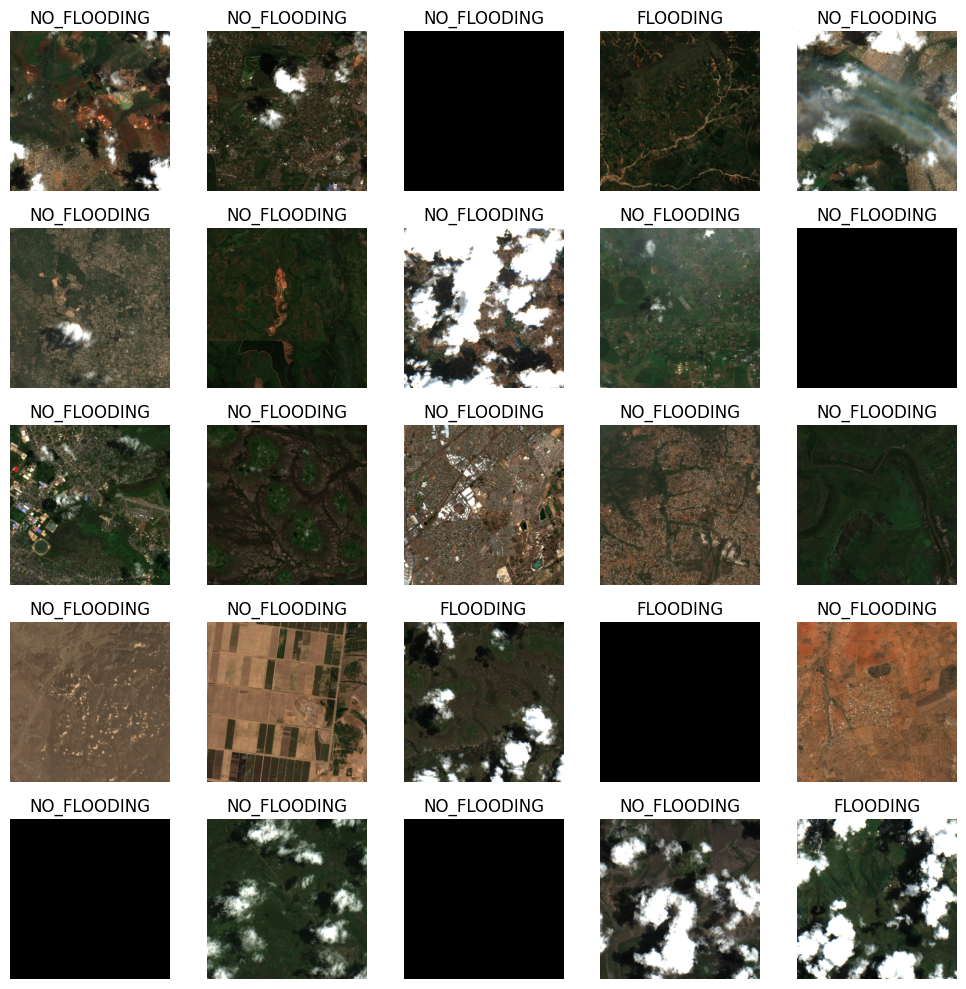

In [12]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
imgs.shape

torch.Size([25, 3, 512, 512])

Let's train an image classifier on this dataset. To do so, we need to define a `task`. In this case, we use the `ImageClassification` task.

In [14]:
ds = SEN12Floods(
    batch_size=64,
    sensor=Sensors.S2,
    bands=S2.RGB,
    # bands=S2.B01,
    # bands=[S2.B08, S2.B02, S2.B01],
    num_workers=4,
    pin_memory=True,
) 

model = timm.create_model(
    'resnet18',
    pretrained='imagenet',
    in_chans=ds.num_bands,
    num_classes=ds.num_classes,
)

task = ImageClassification(model, num_classes=ds.num_classes)

trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=5,
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | ResNet             | 11.2 M
1 | loss_fn | CrossEntropyLoss   | 0     
2 | acc     | MulticlassAccuracy | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Training samples 1342
Validation samples 447
Test samples 447


Sanity Checking: 0it [00:00, ?it/s]

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Once the model is trained, we can evaluate it on the test set to compute the final metrics.

In [15]:
trainer.test(dataloaders=ds.test_dataloader())

/home/juan/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Restoring states from the checkpoint path at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_21/checkpoints/epoch=4-step=105.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/juan/Desktop/pytorch_eo/examples/lightning_logs/version_21/checkpoints/epoch=4-step=105.ckpt


Training samples 1342
Validation samples 447
Test samples 447


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8523489832878113     │
│         test_loss         │    0.33546486496925354    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.33546486496925354, 'test_acc': 0.8523489832878113}]

And also use it to predict labels on new images.

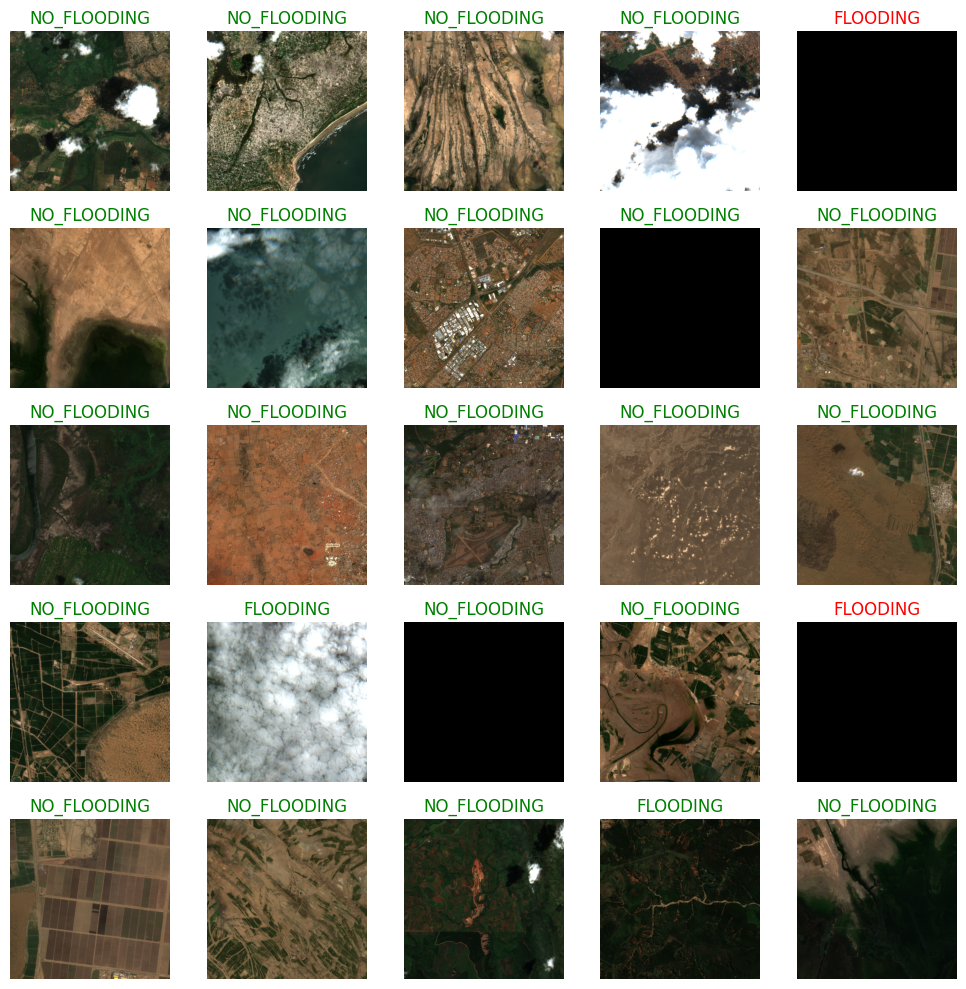

In [16]:
import matplotlib.pyplot as plt

# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()

Feel free to experiment with different bands combinations, data augmentations, hyperparameters, etc. to get better results.